# MIXLORA: Enhancing Large Language Models Fine-Tuning with LoRA-based Mixture of Experts

## Abstract

MIXLORA is a resource-efficient sparse MoE built on top of LoRA. MIXLORA adds multiple LoRA-based experts inside the feed-forward blocks of a frozen dense model, using a standard top-k router to select experts. Unlike other LoRA-MoE approaches, it also uses independent LoRA adapters in the attention layers to boost performance, and adds an auxiliary load-balancing loss to prevent the router from overusing a few experts.

Results show ~9% higher accuracy than state-of-the-art PEFT methods in multi-task settings. It is also introduced a high-throughput framework that cuts GPU memory by 40% and reduces token latency by 30% during both training and inference.

# Introduction


Instruction fine-tuning has made LLMs highly effective across many NLP tasks, and larger models tend to generalize better by learning complex language patterns. But instruction tuning creates a trade-off: better downstream performance usually requires much more compute and memory.

To reduce the cost of full fine-tuning, parameter-efficient fine-tuning (PEFT) methods were introduced. A leading PEFT method is LoRA, which freezes the pretrained model and adds small low-rank matrices to approximate weight updates, achieving performance close to full fine-tuning at much lower cost. Even so, LoRA often still trails full fine-tuning. Newer variants like LoRA+ and DoRA try to close this gap by improving how parameters are updated.

A key limitation is that LoRA-style methods struggle with multi-task learning: the small number of trainable parameters and catastrophic forgetting can reduce cross-task generalization. Some solutions add task-specific modules and then combine them—e.g., AdapterFusion and LoRAHub—but these typically introduce extra components (like fusion attention or composition mechanisms), which increases training complexity and overhead.

A strong direction is to combine LoRA’s efficiency with the flexibility of Mixture-of-Experts (MoE). The idea is to add multiple LoRA modules as “experts” inside transformer sublayers (attention and/or FFN), use a router to choose which experts process each token, and add a load-balancing loss so tokens don’t all get sent to the same expert.

Most existing LoRA-MoE approaches are designed for specialized use cases (e.g., medical multi-task learning or reducing knowledge forgetting), and only a couple (MoELoRA and MOLA) aim at improving general capability. Even then, these methods don’t fully address true multi-task learning, which limits their effectiveness.

Some LoRA-MoE methods place multiple LoRA adapters within one transformer block instead applying them in both attention and FFN. This technique naturally create an opportunity to improve efficiency using parallel Multi-LoRA computation techniques.

MIXLORA is a method that integrates multiple LoRA adapters into a shared FFN layer and uses them as experts to store task-specific parameter updates during fine-tuning, making the design closer to standard MoE architectures like Mixtral 8x7B. To further improve performance, MIXLORA applies LoRA to the self-attention layer instead of turning attention into an MoE layer. To prevent the router from over-selecting a small subset of experts, the method also adds an auxiliary load-balancing loss.

An implementation a high-throughput framework for both training and inference that removes redundant computation overhead. With these optimizations, MIXLORA achieves about a 30% reduction in per-token computation latency and cuts GPU memory usage by 40% or more during training and inference when running multiple MIXLORA models on a single 24GB consumer GPU, demonstrated using LLaMA2-7B in half precision.

Evaluations of MIXLORA on widely used benchmarks including ARC, BoolQ, OpenBookQA, PIQA, SIQA, HellaSwag, and WinoGrande shows MIXLORA consistently outperforms existing fine-tuning approaches.

## Related Works


As models grow larger, fine-tuning becomes slow and demands substantial memory. To reduce these costs, research explores approaches such as parameter-efficient fine-tuning (PEFT), distillation, quantization, and pruning. Among PEFT methods, LoRA is especially popular because it uses low-rank matrices to represent updates to linear layer weights, improving adaptation while adding no extra inference overhead. Several LoRA variants extend this idea in different ways: VeRA adds learnable scaling vectors on shared frozen random matrices, FedPara uses low-rank Hadamard products for federated learning, Tied-LoRA reduces parameters further through weight tying, AdaLoRA applies SVD(Singular Value Decomposition) and prunes less important singular values to focus updates, and DoRA separates pretrained weights into magnitude and direction and then applies LoRA only for directional updates to reduce trainable parameters efficiently.

In modern transformers, MoE replaces or augments the standard feed-forward sublayer with a set of experts that are sparsely activated, meaning only a few experts are used per token. This allows the model to scale in width and capacity without increasing computation proportionally, because not all parameters are used every time. Different MoE designs mainly vary in how they sample experts and how routing decisions are made.

Recent work applies MoE concepts to LLM adaptation in several ways.
- LLaVA-MoLE routes tokens to domain-specific experts inside transformer layers to reduce conflicts between different data sources and typically improves over a plain LoRA baseline.
- MoRAL, which targets efficient lifelong learning and adaptation to new domains or tasks
- LoRAMoE, which uses a router to combine LoRA modules in a way that helps reduce world-knowledge forgetting
- PESC focuses on converting dense models into sparse MoE models to lower compute and memory costs
- MoE-LoRA introduces a parameter-efficient MoE method that allocates experts layer-wise through MoLA
- MoCLE activates task-specific parameters by grouping instructions into clusters and routing accordingly

## MIXLORA

### Preliminaries

LoRA fine-tunes a model by keeping the original pretrained weights frozen and learning only small additional adaptation parameters that approximate the weight update. A LoRA module adds a low-rank update formed by two matrices B and A.
$$W' = W + BA$$

An MoE layer consists of n experts along with a router. The output $h'$ of an MoE layer for a given hidden states $h$ is determined by:

$$h' = \sum_{i=1}^{n} R(h)_i \, E_i(h)$$

Here, $R(h)_i$ indicates the router’s output for the $i$-th expert, and $E_i(h)$ is the result from the $i$-th expert.

### Architecture of MIXLORA

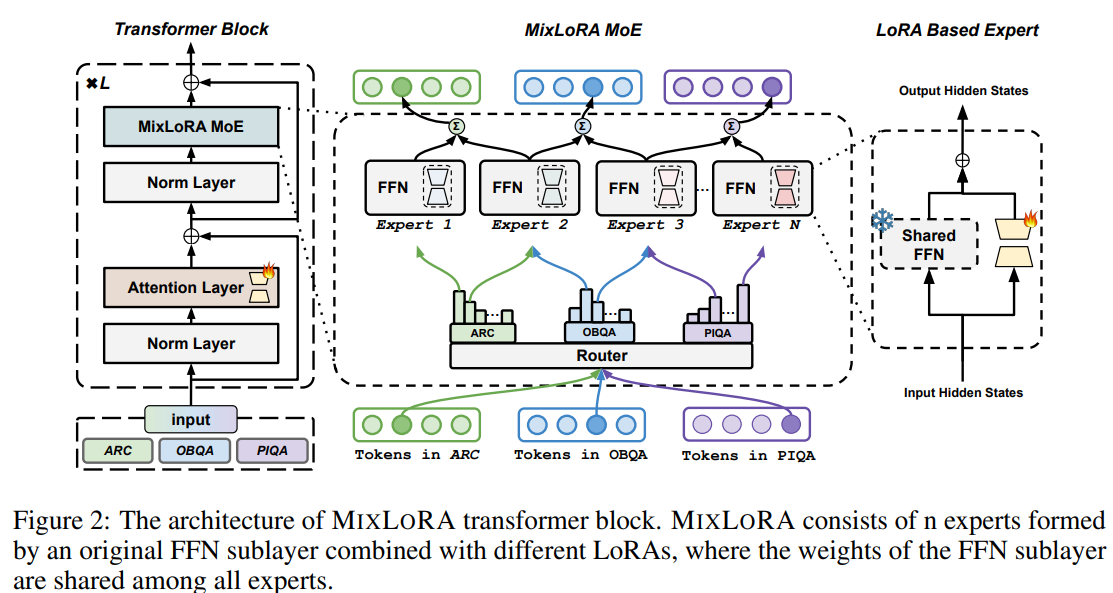

MIXLORA has two main pieces: a transformer layer where the usual feed-forward network (FFN) is replaced by a “mixture” of LoRA-based experts, and a router that decides which experts should process each token.

In a normal transformer block, the model takes the token representations (hidden states), runs them through self-attention, adds a skip connection (residual), then runs the result through one FFN, and adds another skip connection. MIXLORA keeps the self-attention part the same, but swaps the FFN part with MixLoRA.

instead of one FFN, there are several experts. Each expert is built from the same original FFN weights (shared across all experts) plus its own small LoRA update. So the shared FFN is reused to save memory, and only the small LoRA pieces differ between experts, letting each expert specialize.

For every token, a top-k router (in this case top-2) looks at the token’s current representation and scores how suitable each expert is. It turns those scores into probabilities using softmax, then keeps only the best two experts. The token is then processed by those two experts, and their outputs are combined using the router’s weights. This means different tokens, even in the same sentence, can be handled by different experts, and the model can learn to route tokens from different tasks (like ARC, OpenBookQA, PIQA, etc.) to experts that become good at those patterns.

In MoE models, a common problem is that the router starts sending too many tokens to just a few experts. Those experts become overworked, while other experts are rarely used, which wastes capacity and can hurt learning. To reduce this, MIXLORA adds a special extra training penalty called a load-balancing loss.

During training, the model measures how evenly tokens are being distributed across experts. For each expert, it tracks two things. First, $F_i$ is how many tokens actually got sent to that expert (the fraction of tokens where that expert was the top choice). Second, $P_i$ is how much probability the router assigned to that expert on average (even if the expert wasn’t selected, the router still produces probabilities). The auxiliary loss combines these so that experts that get both high probability and high token traffic increase the penalty. Minimizing this penalty encourages the router to spread tokens more evenly across experts instead of collapsing onto a small subset. The loss is scaled by the number of experts so it stays comparable, and it is also multiplied by a small coefficient (about 0.01) so it helps balance experts without overpowering the main training goal (the usual cross-entropy loss for the task).

MIXLORA also improves fine-tuning by adding LoRA adapters to the attention layers, not only the FFN experts. ST-MoE suggests attention fine-tuning can boost results, and MIXLORA follows that by inserting LoRA into the attention projections (q, k, v, and o). Experiments show that this extra LoRA in attention consistently raises average scores compared to using only the FFN-side mixture of LoRA experts.

### Performance Optimization of MIXLORA

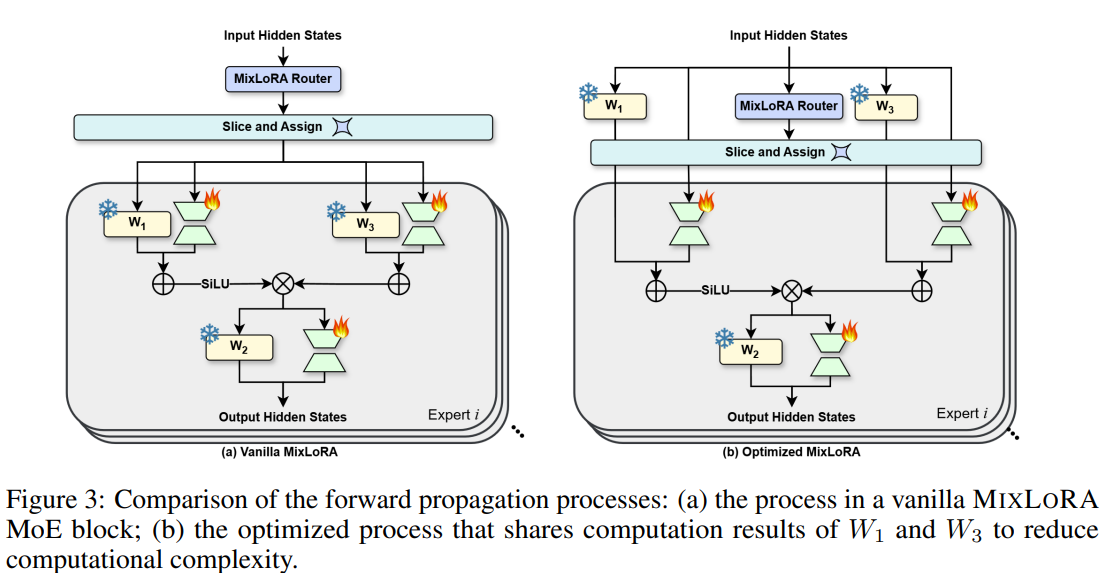

MIXLORA uses several experts, and each expert shares the same frozen FFN weights but has its own small LoRA updates on the FFN’s linear layers. The router chooses K experts per token, so if K is larger, the model ends up doing more repeated work because the same token is processed by multiple experts and then their results are combined. In LLaMA’s FFN, the computation uses three main linear projections (often referred to as W1, W2, and W3), and the FFN output depends on applying W1 and W3, combining them with an activation and a multiplication, and then applying W2. In the basic MIXLORA implementation, each expert repeats these FFN computations with its own LoRA-adjusted versions, which becomes expensive for long sequences.

To reduce this cost without changing accuracy, the key trick is to reuse shared computation. Since the base FFN weights are shared, MIXLORA can compute the expensive shared parts once and only “branch” into expert-specific work after that. Concretely, instead of splitting the input tokens first and running W1 and W3 separately inside each chosen expert, the optimized method runs the input through the shared W1 and W3 once (in parallel), then uses the router’s weights to slice or select the relevant parts for each expert. The final W2 step cannot be fully shared in the same way because it depends on the expert-specific combination of the W1 and W3 outputs, but avoiding repeated W1 and W3 computations already removes about one-third of the MoE block’s work. In practice, this reduces per-token latency by around 30% compared to the vanilla approach while keeping the same model quality.

This idea is extended by running multiple MIXLORA models at the same time. When training and inferencing with two or more MIXLORA
models, the multi-task inputs of these models are packed into one bigger batch. It runs that batch once through the shared pretrained weights (especially the big shared projections like W1 and W3), and then apply each model’s own router outputs to slice the intermediate results differently. Because the large pretrained weights are shared across models, this setup cuts memory significantly.

 ## Experiments

Single-task results (ARC-C) on model TinyLlama/TinyLlama-1.1B-Chat-v1.0

Best validation accuracy across 3 epochs:

- LoRA: 29.4%
- DoRA: 27.8%
- MixLoRA: 27.4%
- MixDoRA: 29.1%

Single-task results (ARC-C) on model mistralai/Mistral-7B-Instruct-v0.2

Best validation accuracy across 3 epochs:

- LoRA: 72.6%, max VRAM 55.15 GB, Trainable Parameters: 20.97M
- DoRA: 75.6%, max VRAM 46.73 GB, Trainable Parameters: 22.35M
- MixLoRA: 73.9%, max VRAM 55.77 GB, Trainable Parameters: 121.11M
- MixDoRA: 76.3%, max VRAM 55.47 GB, Trainable Parameters: 129.83M

## Conclusion



In this TinyLlama-1.1B single-task setting, LoRA achieves the best performance, while MixDoRA is very close. MixLoRA and DoRA underperform relative to LoRA. This indicates that, under limited training on a small base model, the mixture-of-experts routing in MixLoRA/MixDoRA does not reliably yield gains over the standard LoRA baseline.

 In this Mistral-7B-Instruct-v0.2 single-task setting MixLoRA/MixDoRA can outperform standard LoRA/DoRA when routing learns meaningful specialization across multiple FFN experts, effectively increasing adaptation capacity. DoRA generally improves over LoRA, and MixDoRA may have only a small average advantage over MixLoRA rather than being consistently superior.

The results differ from the paper’s reported, the most likely causes are mismatched trainable-parameter budgets, differences in evaluation protocol (prompting/scoring/splits), and sensitivity to optimization details (auxiliary routing loss weight and schedules).

The paper’s GPU memory savings claims refer to an optimized multi-model framework, so they must be validated with a multi-model efficiency experiment rather than single-run peak VRAM.

## Future work

**Continual learning with dynamic experts**

The idea is to extend MixLoRA so that it can learn new tasks over time without forgetting old ones. Instead of training on all tasks at once, the model learns tasks sequentially. When a new task appears, the model does not change what it has already learned. Instead, it adds new capacity only where needed.

At the beginning, a pretrained language model is selected and fully frozen. None of the original model weights are ever updated. This ensures stability and keeps training efficient.

For the first task, a small number of LoRA experts are initialized and attached to the model layers as in MixLoRA. A router network is also initialized. The router decides which experts should be used for each input token. During training on the first task, only the LoRA experts and the router parameters are updated. The base model remains frozen.

When a new task becomes available, the model does not retrain from scratch. Instead, new LoRA experts are added to the existing expert pool. These new experts are randomly initialized and are intended to capture task-specific knowledge for the new task. All previously trained experts are frozen, meaning their parameters cannot change. This prevents the knowledge learned for earlier tasks from being overwritten.

Training on the new task updates only two components: the newly added experts and the router. The router learns how to route inputs from the new task to the appropriate experts. At the same time, it can still route inputs from old tasks to previously learned experts, which remain unchanged.

Even if experts are frozen, forgetting can still happen if the router stops selecting them. To avoid this, the router behavior on old tasks should not change too much when learning new tasks. This can be done by adding a regularization term or by occasionally training the router on a small set of examples from old tasks. This helps keep the routing decisions stable over time.

As new tasks are added, the number of experts grows. To prevent the model from becoming too large, expert management techniques are applied. Experts that are rarely used can be removed. Experts that behave very similarly can be merged into a single expert. Another option is to use distillation, where a smaller set of experts is trained to imitate the behavior of a larger expert pool.

This approach is useful because it directly addresses catastrophic forgetting. Since old experts are frozen, their knowledge is not destroyed when learning new tasks. It also matches real-world scenarios, where models need to be updated continuously without retraining from scratch.


Evaluation:

To evaluate how well MixLoRA supports long-term learning, the model is trained and tested in a sequential task setting. Tasks are introduced one after another and the model is evaluated after each training phase.
The model is trained on Task 1 and evaluated on Task 1 to establish a baseline performance. Then Task 2. New LoRA experts are added, old experts are frozen, and the model is trained only on Task 2. After training, the model is evaluated on both Task 1 and Task 2. This process continues for all tasks in the sequence.

For task performance, standard metrics are used depending on the task type, such as accuracy, F1 score, or BLEU. These metrics are reported separately for each task after every training stage.

To measure catastrophic forgetting, the difference between the best performance achieved on a task and its current performance is calculated. A large drop indicates strong forgetting, while a small or zero drop indicates good knowledge retention. An average forgetting score can be computed across all tasks to summarize overall stability.

To evaluate long-term learning quality, the average performance across all tasks after each training step should be calculated. This shows whether the model continues to improve overall as new tasks are added or whether learning new tasks harms global performance.

To analyze model growth efficiency, the number of trainable parameters is tracked after each task. Since new experts are added over time, this shows how quickly the model grows. Performance can then be plotted against parameter count to evaluate whether added parameters provide meaningful gains.


# References

https://arxiv.org/pdf/2404.15159

https://github.com/TUDB-Labs/MixLoRA

https://github.com/TUDB-Labs/MoE-PEFT